# [**Une démonstration du clustering K-Means sur les données des chiffres manuscrits**](https://nbviewer.org/github/Franck-PepperLabs/pepper_dsia_skl_doc_fr/blob/main/docs/examples/2_3_cluster/plot_kmeans_digits.ipynb)<br/>([*A demo of K-Means clustering on the handwritten digits data*](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html))

Dans cet exemple, nous comparons les différentes stratégies d'initialisation pour K-means en termes de temps d'exécution et de qualité des résultats.

Comme la vérité terrain est ici connue, nous appliquons également différentes métriques de qualité de grappe pour juger de la qualité de l'ajustement des étiquettes de grappe à la vérité de terrain.

Métriques de qualité de grappe évaluées (voir [**Évaluation des performances de clustering** (2.3.10)](https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation) pour les définitions et les discussions sur les métriques) :

|Sténographie| nom complet|
|-|-|
|homo|score d'homogénéité|
|compl|score de complétude|
|v-meas|V mesure|
|ARI|indice Rand ajusté|
|AMI|information mutuelle ajustée|
|silhouette|coefficient de silhouette|

# Charger le jeu de données

Nous allons commencer par charger le jeu de données `digits`. Cet ensemble de données contient les chiffres manuscrits 0 à 9. Dans le contexte du regroupement, on souhaite regrouper des images de sorte que les chiffres manuscrits sur l'image soient les mêmes.

In [1]:
import numpy as np
from sklearn.datasets import load_digits

data, labels = load_digits(return_X_y=True)
(n_samples, n_features), n_digits = data.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


# Définir notre référentiel d'évaluation

Nous allons d'abord mettre en place notre benchmark d'évaluation. Au cours de ce benchmark, nous avons l'intention de comparer différentes méthodes d'initialisation pour KMeans. Notre benchmark va :
* créer un pipeline qui mettra à l'échelle les données à l'aide d'un [**`StandardScaler`**](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html);
* entraîner et chronométrer le montage du pipeline;
* mesurer les performances du clustering obtenu via différentes métriques.

In [2]:
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler


def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
        metrics.adjusted_mutual_info_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

# Exécuter le benchmark

Nous allons comparer trois approches :
* une initialisation avec `kmeans++`. Cette méthode est stochastique et nous exécuterons l'initialisation 4 fois ;
* une initialisation aléatoire. Cette méthode est également stochastique et nous exécuterons l'initialisation 4 fois ;
* une initialisation basée sur une projection [**`PCA`**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html). En effet, nous allons utiliser les composants de la [**`PCA`**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) pour initialiser KMeans. Cette méthode est déterministe et une seule initialisation suffit.

In [3]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=data, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=data, labels=labels)

pca = PCA(n_components=n_digits).fit(data)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=data, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	AMI	silhouette
k-means++	0.189s	69545	0.598	0.645	0.621	0.469	0.617	0.153
random   	0.052s	69735	0.681	0.723	0.701	0.574	0.698	0.176
PCA-based	0.015s	72686	0.636	0.658	0.647	0.521	0.643	0.152
__________________________________________________________________________________


# Visualiser les résultats sur les données réduites par PCA

La [**`PCA`**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) permet de projeter les données de l'espace d'origine à 64 dimensions dans un espace de dimension inférieure. Par la suite, nous pouvons utiliser la [**`PCA`**](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) pour projeter dans un espace à 2 dimensions et tracer les données et les grappes dans ce nouvel espace.

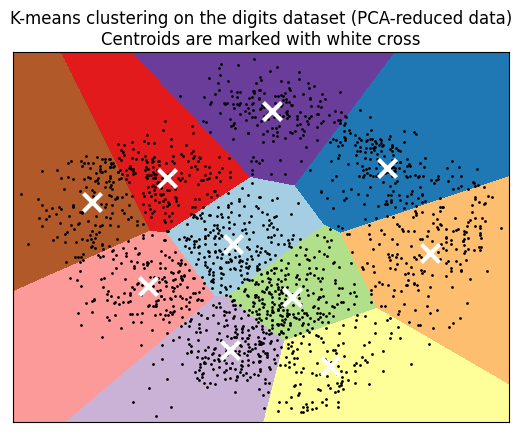

In [4]:
import matplotlib.pyplot as plt

reduced_data = PCA(n_components=2).fit_transform(data)
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4)
kmeans.fit(reduced_data)

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(())
plt.show()